# Анализ маркетинговых расходов Яндекс.Афиши

Целью работы является формирование рекомендаций по оптимизации маркетинговых расходов для сервиса Яндекс.Афиша. Для решения этой задачи следует проанализировать несколько показателей. Во-первых, нас интересует поведение пользователей: насколько много уникальных пользователей, как часто они обращаются к сервису, насколько велика доля новых и, наоборот, возвращающихся пользователей, а также как отличается поведение пользователей разных платформ. Ответ на некоторые из этих вопросов может дать когортный анализ (если позволяют данные). Во-вторых, нас интересует структура маркетинговых расходов в зависимости от времени/платформы/источника и, следовательно, ROI. На основе этих наблюдений можно будет указать на возможные пути приложения маркетинговых усилий (нужно ли больше стремиться к удержанию или привлечению пользователей, каким платформам следует уделить внимание, в какие источники трафика следует больше вложиться и т.д.).

## Содержание <a id='contents'></a>
1. [Загрузка и подготовка данных](#load)
2. [Построение отчет и расчет метрик](#metrics)
- [A. Анализ поведения пользователей](#behaviour)
- [B. Анализ продаж и когортный анализ](#sales)
- [C. Анализ маркетинговых расходов](#marketing)
3. [Общий вывод](#conclusion)

## 1. Загрузка данных и подготовка их к анализу <a id='load'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

from IPython.display import display

warnings.filterwarnings('ignore')

In [2]:
def load(path):
    df = pd.read_csv(path)
    print(df.info())
    print()
    print('Количество полных дубликатов:', df.duplicated().sum())
    return df

### A. Таблица visits 

In [3]:
visits = load(r'visits_log.csv')
visits

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None

Количество полных дубликатов: 0


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


В первой таблице содержатся логи визитов пользователей, с указанием рекламного источника и платформы. Полных дубликатов и пропусков в этой таблице нет, однако для дальнейшей работы следует привести данные в столбцах с датами к типу `datetime`, а в столбцах с _id_ - к типу `string`. Кроме того, можно изменить названия столбцов для удобства в дальнейшей работе.

In [4]:
# переименование столбцов
visits = visits.rename(columns = {'Device': 'device',
                 'End Ts': 'end_session',
                 'Source Id': 'source_id',
                 'Start Ts': 'start_session',
                 'Uid': 'user_id'})

In [5]:
# изменение типов данных
visits['source_id'] = visits['source_id'].astype('str')
visits['user_id'] = visits['user_id'].astype('str')
visits['end_session'] = pd.to_datetime(visits['end_session'])
visits['start_session'] = pd.to_datetime(visits['start_session'])

In [6]:
# проверка
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   device         359400 non-null  object        
 1   end_session    359400 non-null  datetime64[ns]
 2   source_id      359400 non-null  object        
 3   start_session  359400 non-null  datetime64[ns]
 4   user_id        359400 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 13.7+ MB


In [7]:
visits.head()

,device,end_session,source_id,start_session,user_id
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Данные в таблицу _visits_ подготовлены к анализу.

### B. Таблица orders

In [8]:
orders = load(r'orders_log.csv')
orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

Количество полных дубликатов: 0


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


Во второй таблице содержатся логи заказов. Пропусков и дубликатов нет. Аналогично, изменим типы данных на `datetime` (даты покупок) и `string` (_id_ пользователей), а также переименуем столбцы.

In [9]:
# переименование столбцов
orders = orders.rename(columns = {'Buy Ts': 'purchase_time',
                 'Revenue': 'revenue',
                 'Uid': 'user_id'})

In [10]:
# изменение типов данных
orders['user_id'] = orders['user_id'].astype('str')
orders['purchase_time'] = pd.to_datetime(orders['purchase_time'])

In [11]:
# проверка
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   purchase_time  50415 non-null  datetime64[ns]
 1   revenue        50415 non-null  float64       
 2   user_id        50415 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB


In [12]:
orders.head()

,purchase_time,revenue,user_id
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Данные в таблицу _orders_ подготовлены к анализу.

### C. Таблица costs

In [13]:
costs = load(r'costs.csv')
costs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None

Количество полных дубликатов: 0


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


В таблице приведены маркетинговые расходы в день на каждый источник. Пропусков и дубликатов нет. Как и в двух других таблицах, изменим типы данных на `datetime` (в столбце с датой) и `string` (в столбце с _id_ источника), а также переименуем столбец _dt_.

In [14]:
# переименование столбца
costs = costs.rename(columns={'dt': 'date'})

In [15]:
# изменение типов данных
costs['source_id'] = costs['source_id'].astype('str')
costs['date'] = pd.to_datetime(costs['date'])

In [16]:
# проверка
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   object        
 1   date       2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 59.7+ KB


In [17]:
costs.head()

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Все три таблицы подготовлены к анализу.

[Наверх](#contents)

## 2. Построение отчетов и расчет метрик <a id='metrics'></a>

### A. Анализ поведения пользователей <a id='behaviour'></a>

На основе данных о посещениях мы можем рассчитать основные метрики характеризующие поведение пользователей - DAU, WAU, MAU, среднюю продолжительность сессий, среднее число сессий в день и retention rate. Для этого сначала добавим в таблицу _visits_ столбцы с днем, неделей, месяцем и годом, когда началась сессия и продолжительностью сессии (в секундах).

In [18]:
visits['week'] = visits['start_session'].dt.strftime('%Y-%W')
visits['month'] = visits['start_session'].dt.strftime('%Y-%m')
visits['date'] = visits['start_session'].dt.date
visits['year'] = visits['start_session'].dt.year
visits['duration'] = (visits['end_session'] - visits['start_session']).dt.seconds
visits

,device,end_session,source_id,start_session,user_id,week,month,date,year,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-51,2017-12,2017-12-20,2017,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-08,2018-02,2018-02-19,2018,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-26,2017-07,2017-07-01,2017,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-20,2018-05,2018-05-20,2018,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-52,2017-12,2017-12-27,2017,0
...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-30,2017-07,2017-07-29,2017,19
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-04,2018-01,2018-01-25,2018,19
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-09,2018-03,2018-03-03,2018,19
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-44,2017-11,2017-11-02,2017,19


In [19]:
visits['start_session'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_session, dtype: object

Как видно, наши данные о пользовательских визитах охватывают период с 1 июня 2017 до 31 мая 2018 (ровно год), что удобно, поскольку в работе нам не придется делать поправку на неполноту данных за какой-либо месяц, кроме того, мы сможем проследить сезонные изменения.

#### Расчет MAU, WAU и DAU

Поскольку мы хотим оценить эти показатели как для всех пользователей, так и для пользователей отдельных платформ, целесообразно использовать функцию для их расчета.

In [20]:
def mau_wau_dau(df, platform = ''):
    # таблицы с числом уникальных пользователей по месяцам, дням, годам
    mau = df.groupby('month').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'user_count'})
    wau = df.groupby('week').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'user_count'})
    dau = df.groupby('date').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'user_count'})
    # расчет средних значений
    mau_total = int(mau['user_count'].mean()) 
    wau_total = int(wau['user_count'].mean())
    dau_total = int(dau['user_count'].mean())
    # вывод и визуализация результатов
    metrics = {'MAU': [mau, mau_total], 'WAU': [wau, wau_total], 'DAU': [dau, dau_total]}    
    for a in metrics:
        print(f'Среднее значение {a}{platform} равно {metrics[a][1]}')
        print()
        print(f'Значения статистик для {a}{platform}:')
        display(metrics[a][0].describe())
                
        metrics[a][0].plot(kind='line', figsize=(12,9))
        plt.grid(b=True)
        plt.title(f'Значения {a}{platform}')
        plt.xlabel('Период')
        plt.ylabel('Число уникальных пользователей')
        plt.show()

#### Показатели для всех платформ

Среднее значение MAU равно 23228

Значения статистик для MAU:


,user_count
count,12.000000
mean,23228.416667
std,7546.380462
min,11631.000000
25%,17777.000000
50%,24240.500000
75%,28984.750000
max,32797.000000


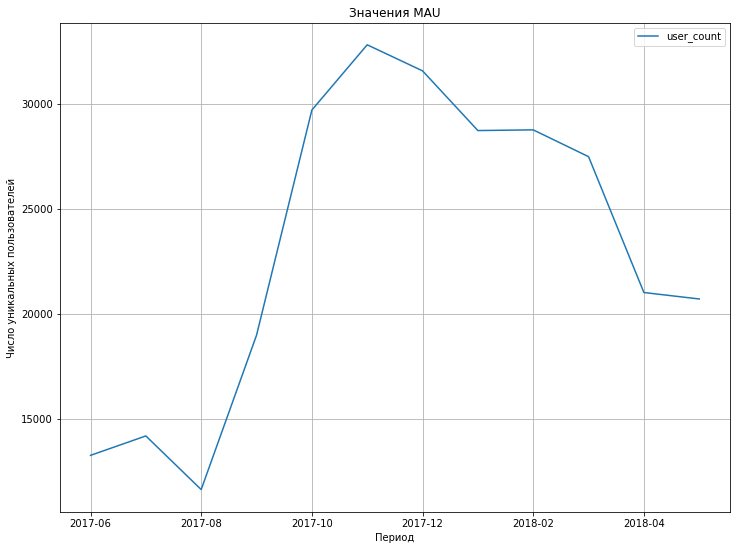

Среднее значение WAU равно 5716

Значения статистик для WAU:


,user_count
count,53.000000
mean,5716.245283
std,2049.898027
min,2021.000000
25%,4128.000000
50%,5740.000000
75%,7401.000000
max,10586.000000


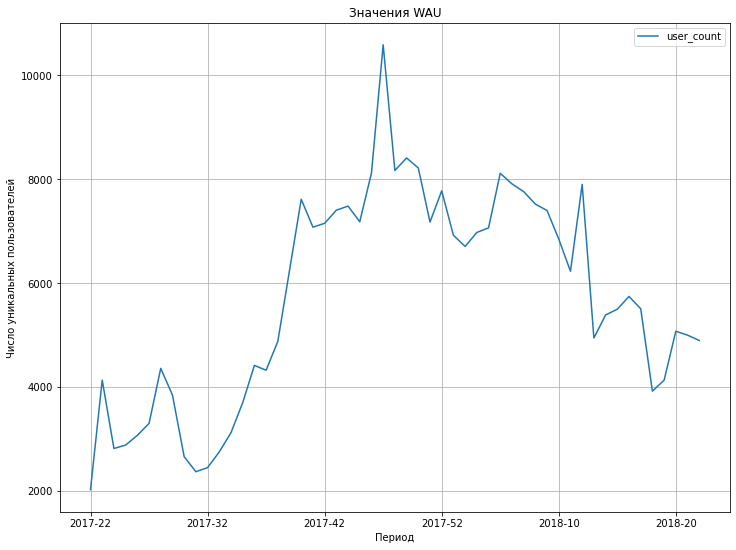

Среднее значение DAU равно 907

Значения статистик для DAU:


,user_count
count,364.000000
mean,907.991758
std,370.513838
min,1.000000
25%,594.000000
50%,921.000000
75%,1173.000000
max,3319.000000


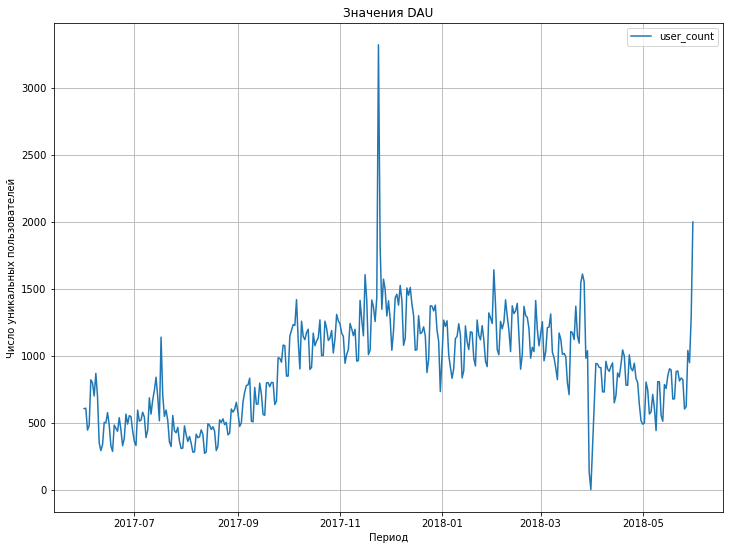

In [21]:
mau_wau_dau(visits)

1. Среднее значение MAU за весь период составляет 23228 уникальных пользователей в месяц. При этом мы наблюдаем существенные колебания в зависимости от месяца (почтив три раза): наименьшее количество пользователей приходится на июль-август 2017 года. Причем это следует объяснять, скорее всего, именно сезонностью (а не, например, меньшим развитием сервиса в предыддущем году): лето - пора отпусков, люди стремятся проводить больше времени на улице на каких-то мероприятиях, плюс, летом закрыт театральный сезон, устраивается меньшее количество выставок, обычно откладывают громкие кинопремьеры и т.д. Та же тенденция явно наблюдается и к лету 2018 года, хотя данные ограничены концом весны. Показатели резко растут с начала осени к ноябрю - это время открытия сезона, премьер, возвращения из отпусков и т.д. Затем мы наблюдаем некоторый плавный спад активности до весны (хотя я бы ожидал некоторого подъема в связи с январскими праздниками) и достаточно резкое снижение после марта, которое, вероятно, должно продолжиться до конца лета.
2. Среднее значение WAU за весь период составляет 5716 уникальных пользователей в неделю. Общая тенденция здесь такая же, как и с MAU - низкие значения летом, резкий рост осенью, постепенное снижение после ноября. Однако мы видим на графике, что некоторые недели показывают заметно большее количество уникальных пользователей по сравнению с соседними неделями. В качестве объяснения можно предположить, что на эти недели приходились какие-то значительные мероприятия, например, премьеры популярных фильмов. Для проверки этой гипотезы можно было бы соотнести "локальные максимумы" (например, 28 и 47 недели 2017 года) с календарем событий либо запросить более детальную информацию о пользовательской активности (например, какие страницы сайта просматривали). 
3. Среднее значение DAU за весь период составляет 907 уникальных пользователей в день. Разброс значений по периодам в целом меньший, чем для MAU и WAU, а общая тенденция сезонной активности сохраняется. Заметим, впрочем, что на этом графике есть несколько ярких выбросов (примерно синхронизированных с "локальными максимумами" WAU). Во-первых, отметим околонулевое значение в конце марта (падение сайта или ошибка логов?), на которое следует обратить внимание технических специалистов. Во-вторых, мы видим несколько пиковых значений. Проанализируем одно из них: в ноябре, втрое превышающее третий квартиль.

In [22]:
dau_all = visits.groupby('date').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'user_count'})

In [23]:
dau_all[dau_all['user_count'] == dau_all['user_count'].max()]

,user_count
date,
2017-11-24,3319


In [24]:
dau_all[dau_all['user_count'] == dau_all['user_count'].min()]

,user_count
date,
2018-03-31,1


Дата, на которую пришлось наибольшее число продаж, - "черная пятница" в 2017 году, традиционный день скидок (если гугл нам не врет). На сайте Я.Афиши есть [список завершившихся акций](https://afisha.yandex.ru/moscow/skidki-i-akcii) с июля 2018 года. Данных об акциях за наш период там нет, однако можно найти [пресс-релизы](https://www.facebook.com/yandex/photos/%D0%B2%D0%BE%D1%82-%D0%BA%D0%B0%D0%BA-%D0%B2%D1%8B%D0%B3%D0%BB%D1%8F%D0%B4%D0%B8%D1%82-%D1%87%D1%91%D1%80%D0%BD%D0%B0%D1%8F-%D0%BF%D1%8F%D1%82%D0%BD%D0%B8%D1%86%D0%B0-%D0%B2-%D1%8F%D0%BD%D0%B4%D0%B5%D0%BA%D1%81%D0%B5-%D1%83-%D0%BD%D0%B0%D1%81-%D1%82%D0%BE%D0%B6%D0%B5-%D0%BC%D0%BD%D0%BE%D0%B3%D0%BE-%D1%81%D0%BA%D0%B8%D0%B4%D0%BE%D0%BA-%D1%81%D0%BA%D0%B8%D0%B4%D0%BA%D0%B0-30-%D0%BD%D0%B0-%D0%BB/10160980515085577/) о скидках на Я.Афише в интересующий нас день. Кроме того, по данным 2018-2020 годов можно сделать вывод, что Я.Афиша устраивает акции со скидками в марте, июле, ноябре и конце декабря, что в основном соответствует относительно высоким значениям пользовательской активности, по-видимому, такой календарь акций можно экстраполировать и на 2017-2018 годы. Следовательно, акции были вполне успешны, по крайней мере, с точки зрения привлечения пользователей.  
Для дальнейшего исследования сравним активность пользователей разных платформ.

#### Показатели активности по платформам

Среднее значение MAU (ПК) равно 16724

Значения статистик для MAU (ПК):


,user_count
count,12.000000
mean,16724.916667
std,5533.916769
min,8611.000000
25%,12668.000000
50%,17209.000000
75%,20752.000000
max,24439.000000


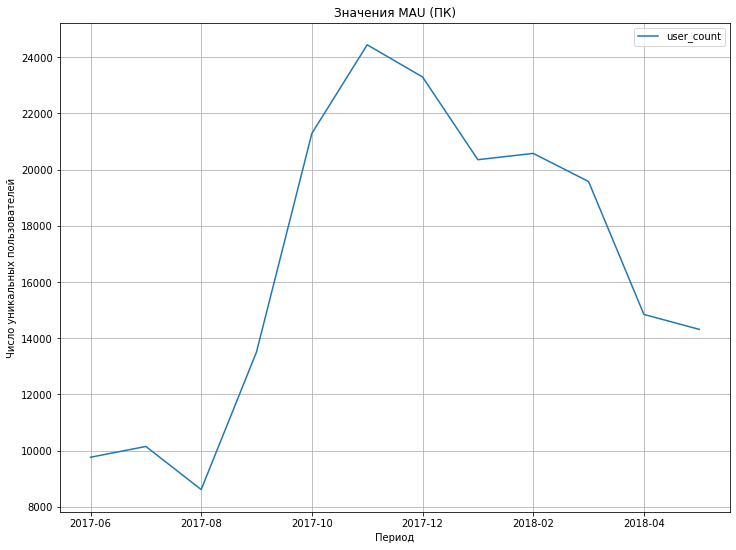

Среднее значение WAU (ПК) равно 4129

Значения статистик для WAU (ПК):


,user_count
count,53.000000
mean,4129.509434
std,1508.799760
min,1451.000000
25%,2945.000000
50%,4061.000000
75%,5347.000000
max,7979.000000


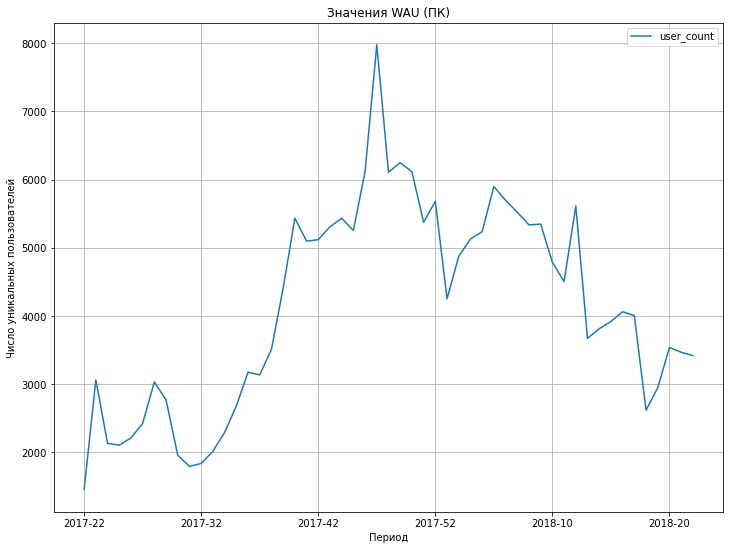

Среднее значение DAU (ПК) равно 659

Значения статистик для DAU (ПК):


,user_count
count,364.000000
mean,659.244505
std,284.771685
min,1.000000
25%,421.750000
50%,649.000000
75%,877.000000
max,2605.000000


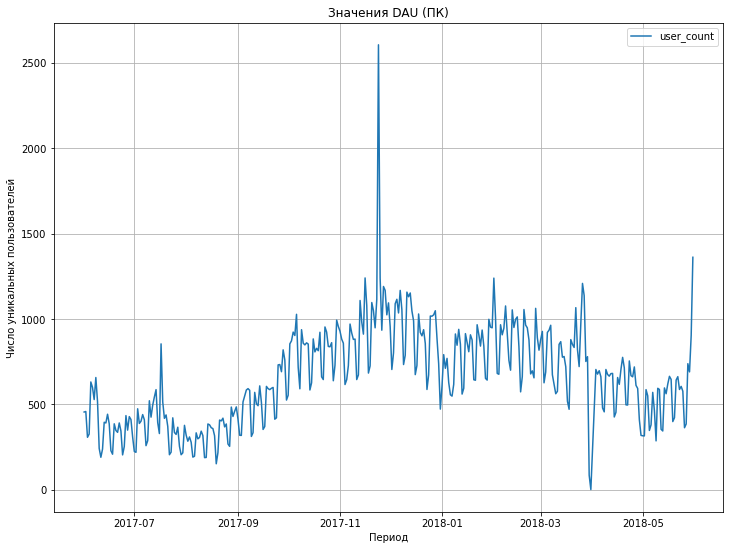

In [25]:
mau_wau_dau(visits.query('device == "desktop"'), ' (ПК)')

Среднее значение MAU (мобильные платформы) равно 6825

Значения статистик для MAU (мобильные платформы):


,user_count
count,12.000000
mean,6825.916667
std,2201.062903
min,3132.000000
25%,5315.000000
50%,7475.000000
75%,8752.000000
max,8913.000000


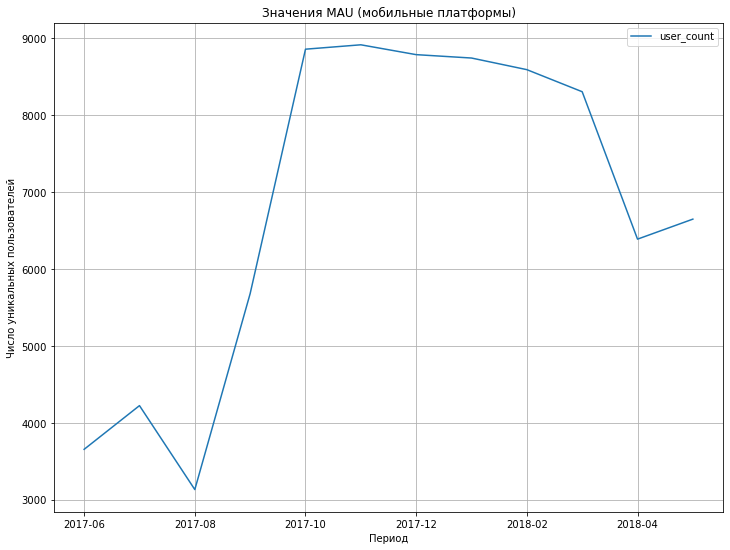

Среднее значение WAU (мобильные платформы) равно 1634

Значения статистик для WAU (мобильные платформы):


,user_count
count,53.000000
mean,1634.924528
std,591.655235
min,584.000000
25%,1208.000000
50%,1724.000000
75%,2126.000000
max,2785.000000


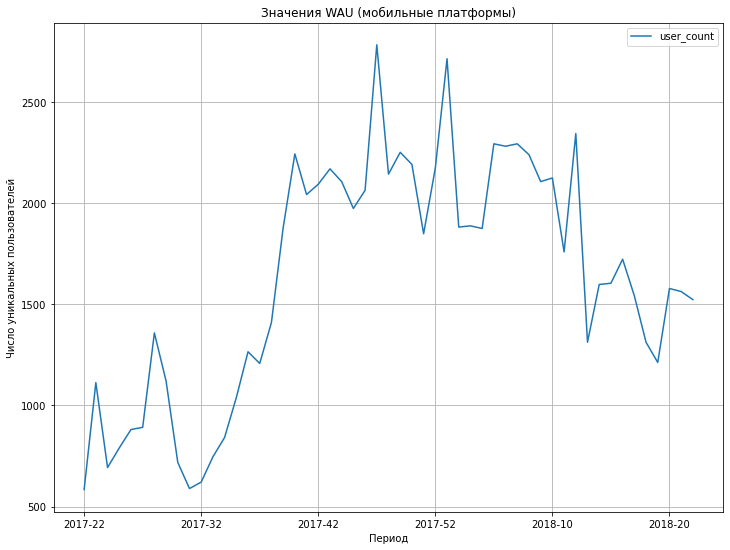

Среднее значение DAU (мобильные платформы) равно 252

Значения статистик для DAU (мобильные платформы):


,user_count
count,363.000000
mean,252.873278
std,102.042757
min,46.000000
25%,173.500000
50%,264.000000
75%,322.000000
max,777.000000


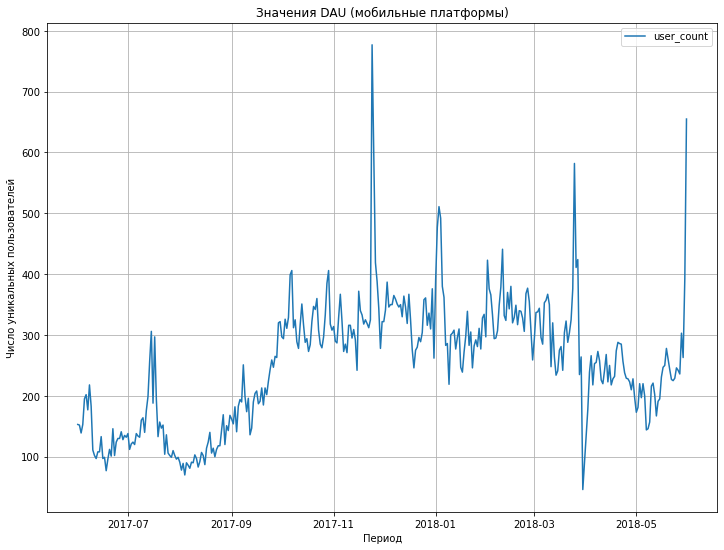

In [26]:
mau_wau_dau(visits.query('device == "touch"'), ' (мобильные платформы)')

В среднем примерно четверть активных пользователей пользуются ПК, остальные - мобильными платформами. В целом активность пользователей разных платформ отличается мало и соответствует общим тенденциям, за исключением того, что пользователи мобильных платформ демонстрируют достаточно ровное значение MAU с октября по март. При этом в WAU в этот же период для них свойственны подъемы и спады. Из необычных особенностей пользователей мобильных платформ отметим также высокую активность в начале года, а не в конце.

#### Анализ среднего числа сессий

Рассчитаем среднее количество сессий в день (всего и на пользователя) по месяцам и за все наблюдения.

In [27]:
session_per_day = visits.groupby(['month', 'date']).agg({'start_session': 'count', 'user_id': 'nunique'})

count    364.000000
mean       1.082170
std        0.020876
min        1.000000
25%        1.070321
50%        1.082488
75%        1.093876
max        1.217837
Name: session_per_user, dtype: float64

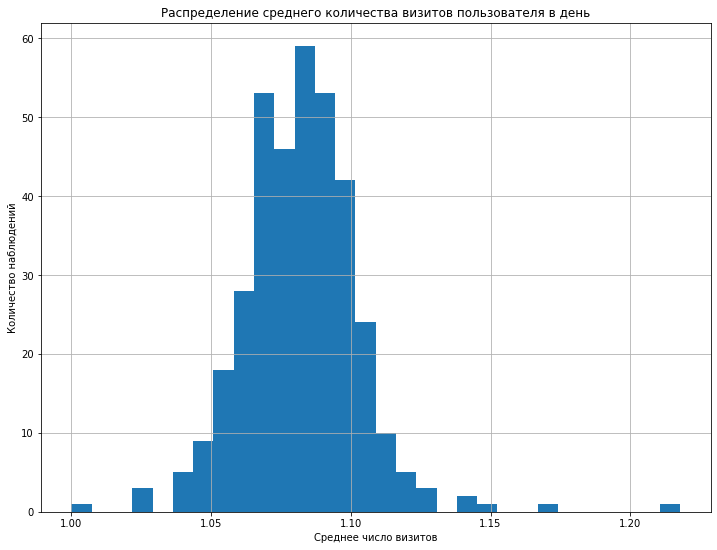

In [28]:
# количество сессий на пользователя в день:
session_per_day['session_per_user'] = session_per_day['start_session'] / session_per_day['user_id']
display(session_per_day['session_per_user'].describe())
session_per_day['session_per_user'].hist(bins=30, figsize=(12,9))
plt.title('Распределение среднего количества визитов пользователя в день')
plt.xlabel('Среднее число визитов')
plt.ylabel('Количество наблюдений');

count     364.000000
mean      987.362637
std       418.994796
min         1.000000
25%       635.500000
50%      1003.000000
75%      1280.000000
max      4042.000000
Name: start_session, dtype: float64

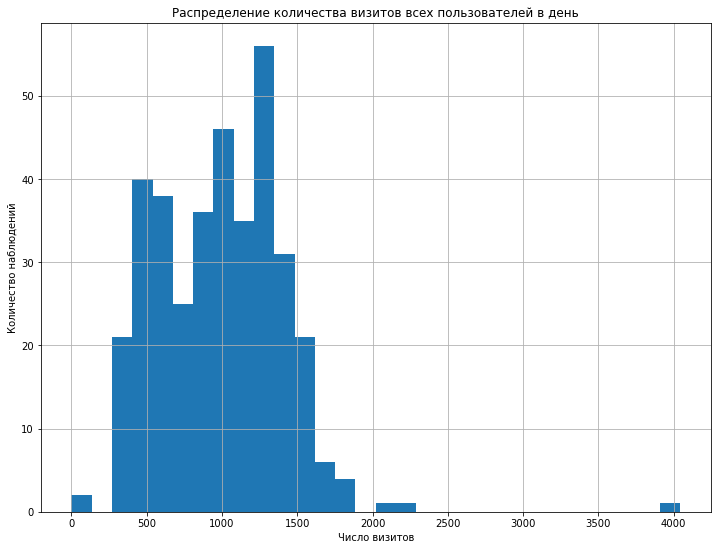

In [29]:
display(session_per_day['start_session'].describe())
session_per_day['start_session'].hist(bins=30, figsize=(12,9))
plt.title('Распределение количества визитов всех пользователей в день')
plt.xlabel('Число визитов')
plt.ylabel('Количество наблюдений');

In [30]:
# убедимся, что выброс приходится на 24 ноября 2017
session_per_day.query('start_session == start_session.max()')

,,start_session,user_id,session_per_user
month,date,,,
2017-11,2017-11-24,4042,3319,1.217837


In [31]:
# функция для построения line plot, который здесь и далее будет применяться для визуализации динамики в течение года
def line_plot(series, title=str, xlabel=str, ylabel=str):
    display(series.describe())
    series.plot(grid=True, figsize=(12,9))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);

count      12.000000
mean      989.314802
std       343.403324
min       463.064516
25%       741.449194
50%      1032.622914
75%      1248.990207
max      1465.633333
Name: session_per_day, dtype: float64

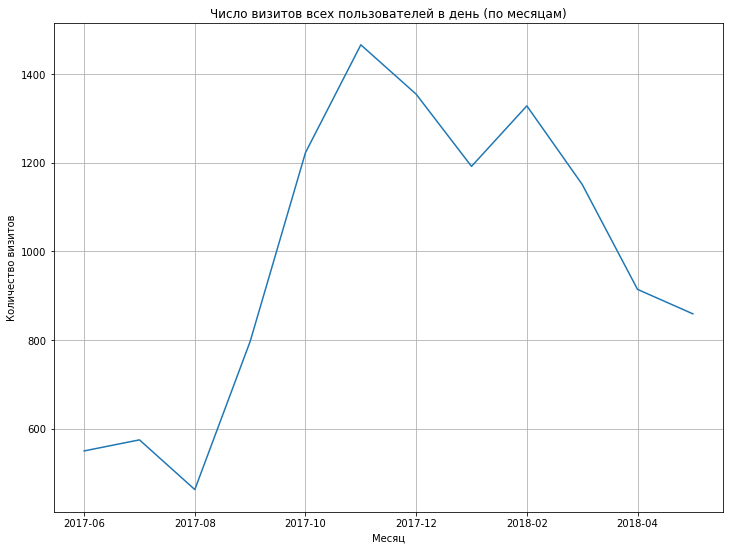

In [32]:
# количество сессий в день по месяцам:
session_per_day_monthly = (session_per_day.reset_index()
                           .groupby('month')
                           .agg({'start_session': 'sum', 'date': 'count'}))
session_per_day_monthly['session_per_day'] = session_per_day_monthly['start_session'] / session_per_day_monthly['date']
line_plot(session_per_day_monthly['session_per_day'],
         title='Число визитов всех пользователей в день (по месяцам)',
         xlabel='Месяц',
         ylabel='Количество визитов')

1. В среднем каждый день наш сайт посещают 987 пользователей, в 75% случаев их число не превышает 1280. Отдельные выбросы (до 4000), по-видимому, соответствуют тем пикам DAU, о которых шла речь выше (во всяком случае, 24 ноября совпадает). Это можно использовать для более глубокой оценки результатов маркетинговых акций: например, сравнить долю новых и уникальных пользователей в эти дни со средними значениями.
2. Большинство пользователей не заходят на сайт больше одного раза в день, значение числа сессий на пользователя в день имеет небольшой разброс и не превышает 1.1.
3. Общее количество пользовательских сессий в день существенно меняется в зависимости от месяца. В целом эта картина соответствует отмеченные выше изменениям MAU, по-видимому, ее следует интерпретировать аналогичным образом.

#### Анализ средней продолжительности сессии

Построим гистограммы для оценки распределения продолжительности сессий (в целом и по платформам) и выбора подходящей меры центральной тенденции. Для большей наглядности исключим слишком большие значения.

In [33]:
def session_hist(df, platform = ''):
    print(df[df['duration'] < 8000].duration.describe())
    df[df['duration'] < 8000].duration.hist(bins=30, figsize=(12,9))
    plt.title(f'Распределение продолжительности сессий{platform}')
    plt.xlabel('Продолжительность сессии, секунд')
    plt.ylabel('Число наблюдений');

count    358734.000000
mean        623.033646
std         863.388277
min           0.000000
25%          60.000000
50%         300.000000
75%         840.000000
max        7980.000000
Name: duration, dtype: float64


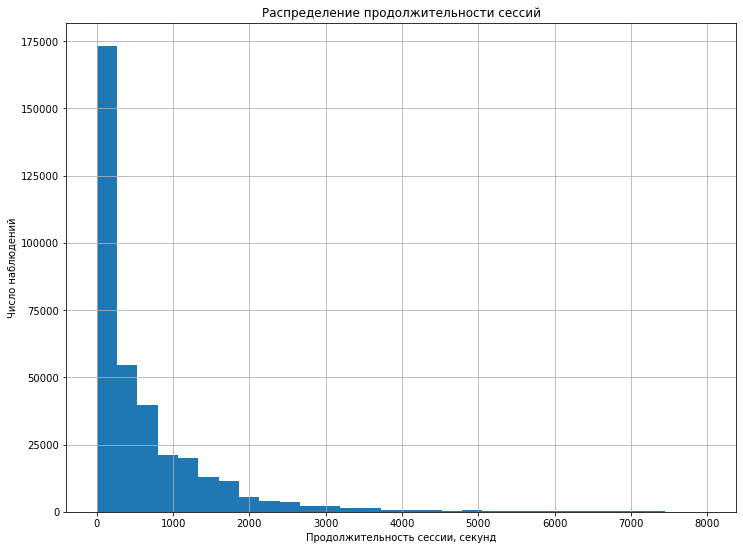

In [34]:
session_hist(visits)

count    261966.000000
mean        678.884611
std         915.625142
min           0.000000
25%         120.000000
50%         360.000000
75%         900.000000
max        7980.000000
Name: duration, dtype: float64


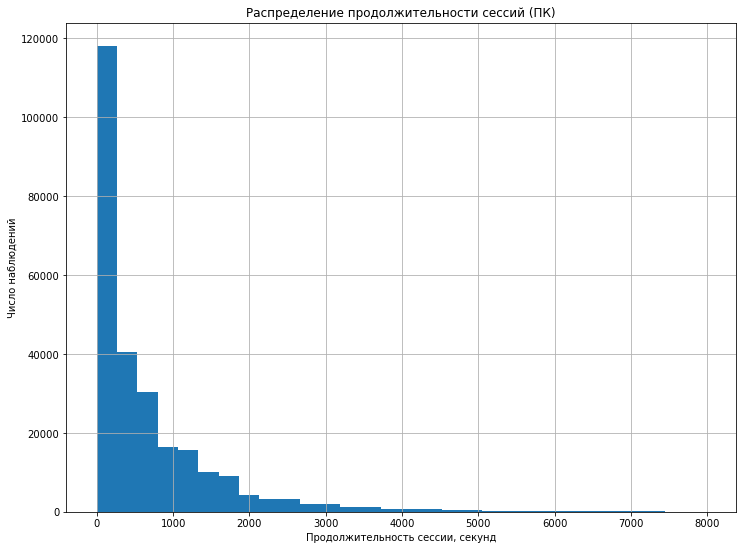

In [35]:
session_hist(visits.query('device == "desktop"'), ' (ПК)')

count    96768.000000
mean       471.836413
std        680.120413
min          0.000000
25%         60.000000
50%        180.000000
75%        600.000000
max       7860.000000
Name: duration, dtype: float64


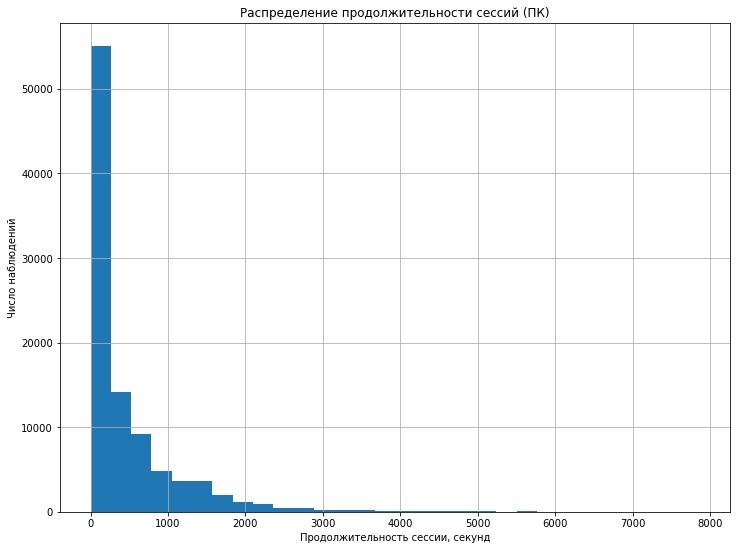

In [36]:
session_hist(visits.query('device == "touch"'), ' (ПК)')

Распределения во всех трех выборках значительно отличаются от нормального, поэтому в качестве меры центральной тенденции применим моду.

In [37]:
print('Средняя продолжительность (мода) сессии:')
visits['duration'].mode()

Средняя продолжительность (мода) сессии:


0    60
dtype: int64

In [38]:
print('Средняя продолжительность (мода) сессии на ПК:')
visits.query('device == "desktop"').duration.mode()

Средняя продолжительность (мода) сессии на ПК:


0    60
dtype: int64

In [39]:
print('Средняя продолжительность (мода) сессии на мобильных платформах:')
visits.query('device == "touch"').duration.mode()

Средняя продолжительность (мода) сессии на мобильных платформах:


0    60
dtype: int64

In [40]:
visits[visits['duration'] == 60].count()

device           53029
end_session      53029
source_id        53029
start_session    53029
user_id          53029
week             53029
month            53029
date             53029
year             53029
duration         53029
dtype: int64

Таким образом, можно сказать, что в среднем пользователь проводит на сайте минуту, причем этот показатель не отличается для разных платформ, распределение также существенно не различается. Несмотря на это, у нас есть и гораздо более "долгие" пользователи, число их относительно невелико, но средние значения из-за них достаточно сильно отличаются от моды: они составляют 623, 679 и 472 секунды для трех рассмотренных категорий. Вероятно, это связано с тем, что некоторая часть пользователей заходит на сайт без определенного намерения купить (или узнать) о чем-то конкретном и тратит достаточно много времени на чтение. При необходимости более детального сопоставления пользователей разных платформ наши наблюдения можно развить, проведя t-тест для выявления значимости разницы в средней длительности сессий, однако для этого требуется специальная подготовка данных: необходимо проанализировать и удалить выбросы. Заметим также, что в нашей выборке есть пользователи с нулевой длительностью сессий - об этом надо сообщить техническим специалистам.

[Наверх](#contents)

### B. Анализ продаж и когортный анализ <a id='sales'></a>

#### Средний чек

In [41]:
orders.revenue.describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [42]:
orders[orders['revenue'] > 500]

,purchase_time,revenue,user_id
9229,2017-09-26 22:45:00,550.00,16152080406371512880
23165,2017-12-10 13:04:00,1195.64,5539673724080479777
23244,2017-12-10 20:17:00,2633.28,5539673724080479777
24341,2017-12-15 21:22:00,604.39,5539673724080479777
24607,2017-12-17 18:06:00,1109.10,11149926373378902217
32473,2018-02-01 19:28:00,607.44,11149926373378902217
36522,2018-02-23 08:54:00,1236.28,11149926373378902217
36682,2018-02-24 09:25:00,1221.37,11149926373378902217
40020,2018-03-15 19:22:00,856.78,11149926373378902217
40386,2018-03-18 09:13:00,1073.11,11149926373378902217


In [43]:
print('Средний чек составляет {:.2f} тыс. руб.'.format(orders.revenue.mean()))

Средний чек составляет 5.00 тыс. руб.


Проанализируем динамику по месяцам.

In [44]:
orders['month'] = orders['purchase_time'].dt.strftime('%Y-%m')

,revenue
count,13.000000
mean,4.838700
std,0.656336
min,3.420000
25%,4.771279
50%,4.847139
75%,5.306589
max,5.852139


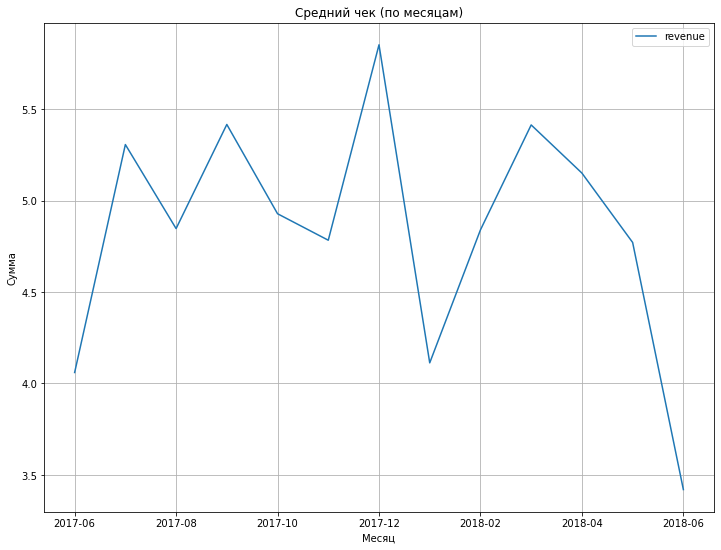

In [45]:
avg_revenue_per_month = orders.groupby('month').agg({'revenue': 'mean'})
line_plot(avg_revenue_per_month,
        title='Средний чек (по месяцам)',
        xlabel='Месяц',
        ylabel='Сумма')

Средний чек на нашем сайте составляет 5 тысяч рублей (?, в задании не указаны единицы), однако 75% покупок меньше этого значения, что говорит об очень больших выбросах (да и в таблице есть значения отличающиеся от средних на порядок и больше). Динамика среднего чека отличается от динамики активности, рассмотренной выше: самый большой средний чек - в декабре. На этот месяц приходятся четыре значения, превосходящие среднее в 10 и более раз (в том числе максимум, который больше в 50 с лишним раз). Кроме того, возможно, высокий средний чек связан с дороговизной околоновогодних мероприятий и покупками в подарок. Наименьшее значение среднего чека - в январе. В ноябре, самом "активном" месяце, средний чек относительно невысокий, видимо, из-за покупок по скидкам. Заметим также, что из 13 самых дорогих покупок 12 приходятся на двух пользователей.

Для ответов на вопросы о том, как часто люди возвращаются, сколько покупок совершают по периодам, в какой момент начинают покупать и сколько денег приносят, проведем когортный анализ. Разделим всех пользователей на когорты по месяцам, а затем для каждой когорты рассчитаем: 1) Retention Rate, 2) сумму покупок по месяцам, 3) число покупок по месяцам, 4) LTV.

In [46]:
# список всех пользовательских 
cohorts = visits.pivot_table(index='user_id', values='month', aggfunc='min').reset_index()
cohorts

,user_id,month
0,10000171586432207426,2017-12
1,10000344846682484395,2018-02
2,1000036778515242839,2017-09
3,10000460875579931334,2017-09
4,10000558740593440652,2018-01
...,...,...
228164,9999530179466660745,2017-06
228165,9999704916412649026,2017-06
228166,9999829453910784044,2017-11
228167,9999912853550499774,2017-08


In [47]:
cohorts = cohorts.rename(columns={'month': 'cohort'})
cohorts_total = cohorts.groupby('cohort').agg({'user_id': 'count'}).rename(columns={'user_id': 'user_count'})

,user_count
count,12.000000
mean,19014.083333
std,5696.401184
min,10181.000000
25%,14769.500000
50%,18646.500000
75%,23285.000000
max,27248.000000


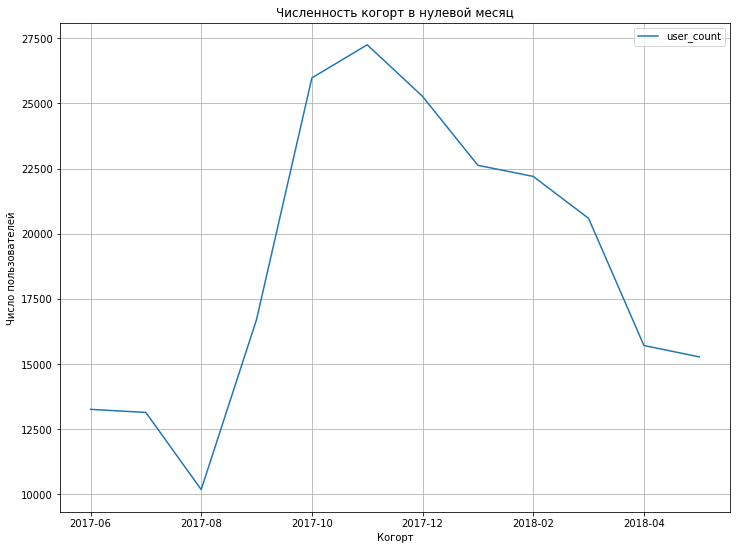

In [48]:
line_plot(cohorts_total,
         title='Численность когорт в нулевой месяц',
         xlabel='Когорт',
         ylabel='Число пользователей')

Чимленность отдельных когорт в нулевой месяц (то есть новых пользователей в этот месяц) в целом напоминает уже знакомую картину годовой динамики: спад летом (особенно в августе, в июле он, вероятно, несколько смягчается акцией), резкий рост осенью с пиком в ноябре (видимо, из-за "черной пятницы"), затем снижение зимой и весной. Интересно, что акции в декабре и марте на этом графике не видны. Рассчитаем число пользователей, retention rate, изменение среднего чека и LTV для каждой когорты.

#### Анализ числа пользователей и retention rate по когортам

In [49]:
visits_by_cohort = visits[['user_id', 'month']].merge(cohorts, on='user_id', how='left')
visits_by_cohort

,user_id,month,cohort
0,16879256277535980062,2017-12,2017-12
1,104060357244891740,2018-02,2018-02
2,7459035603376831527,2017-07,2017-07
3,16174680259334210214,2018-05,2018-03
4,9969694820036681168,2017-12,2017-12
...,...,...,...
359395,18363291481961487539,2017-07,2017-07
359396,18370831553019119586,2018-01,2018-01
359397,18387297585500748294,2018-03,2018-03
359398,18388616944624776485,2017-11,2017-11


In [50]:
visits_by_cohort['month'] = pd.to_datetime(visits_by_cohort['month'], format='%Y-%m')
visits_by_cohort['first_visit'] = pd.to_datetime(visits_by_cohort['cohort'], format='%Y-%m')

In [51]:
visits_by_cohort['age'] = ((visits_by_cohort['month'] - visits_by_cohort['first_visit']) 
                           / np.timedelta64(1, 'M')).round().astype(int)

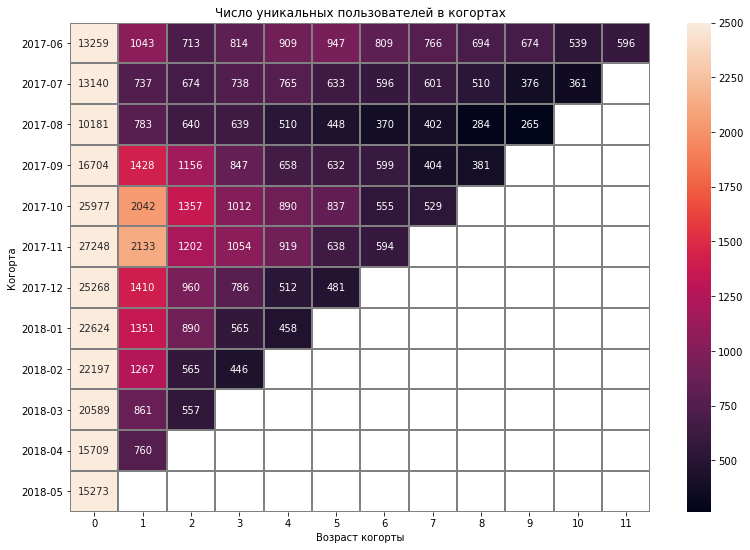

In [52]:
cohorts_retention = visits_by_cohort.pivot_table(index='cohort',
                                                 columns='age',
                                                 values='user_id',
                                                 aggfunc='nunique')
plt.figure(figsize=(13, 9))
sns.heatmap(cohorts_retention, annot=True, fmt='.0f', linewidths=1, linecolor='gray', vmax=2500)
plt.title('Число уникальных пользователей в когортах')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта');

In [53]:
cohort_users = visits_by_cohort.pivot_table(index=['cohort', 'age'], aggfunc={'user_id': 'nunique'}).reset_index()
cohort_zero_users = cohort_users[cohort_users['age'] == 0]
cohort_zero_users = cohort_zero_users.rename(columns={'user_id':'total_users'})
cohort_users = cohort_users.merge(cohort_zero_users[['cohort', 'total_users']], on='cohort')
cohort_users['retention'] = cohort_users['user_id'] / cohort_users['total_users']

In [54]:
retention = cohort_users.pivot_table(index='cohort',
                                     columns='age',
                                     values='retention')

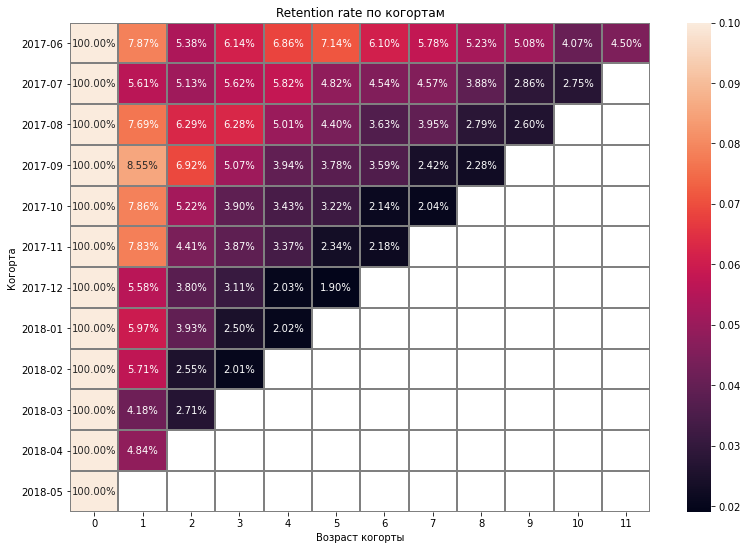

In [55]:
plt.figure(figsize=(13, 9))
sns.heatmap(retention, annot=True, fmt='.2%', linewidths=1, linecolor='gray', vmax=0.1)
plt.title('Retention rate по когортам')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта');

Показатели удержания пользователей невысоки: уже во второй месяц число представителей всех когорт уменьшается более чем в десять раз и в дальнейшем снижается еще сильнее, за редкими исключениями (см., например, 11-й месяц первой когорты). Наиболее высокие показатели удержания - у первой из исследованных когорт (июнь 2017), он превышает 4% даже спустя год, тогда как у остальных когорт он достаточно быстро снижается до 2-3%. Более того, эта когорта в абсолютном выражении уступает только двум наиболее недавним когортам. Имея в виду эти оговорки, можно все же заключить, что абсолютное большинство людей пользуется сервисом единоразово и не имеет склонности возвращаться. Retention rate в целом не отличается для "акционных" и обычных месяцев.

#### Анализ продаж по когортам

In [56]:
cohort_orders = orders.merge(cohorts, on='user_id')
cohort_orders

,purchase_time,revenue,user_id,month,cohort
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06,2017-06
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05,2018-05
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05,2018-05
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05,2018-05
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05,2017-10


In [57]:
cohort_orders['month'] = pd.to_datetime(cohort_orders['month'], format='%Y-%m')
cohort_orders['first_visit'] = pd.to_datetime(cohort_orders['cohort'], format='%Y-%m')
cohort_orders['age'] = ((cohort_orders['month'] - cohort_orders['first_visit'])
                        / np.timedelta64(1, 'M')).round().astype(int)

In [58]:
cohort_purchases = cohort_orders.pivot_table(index='cohort', columns='age',
                                            values = 'revenue', aggfunc='count')

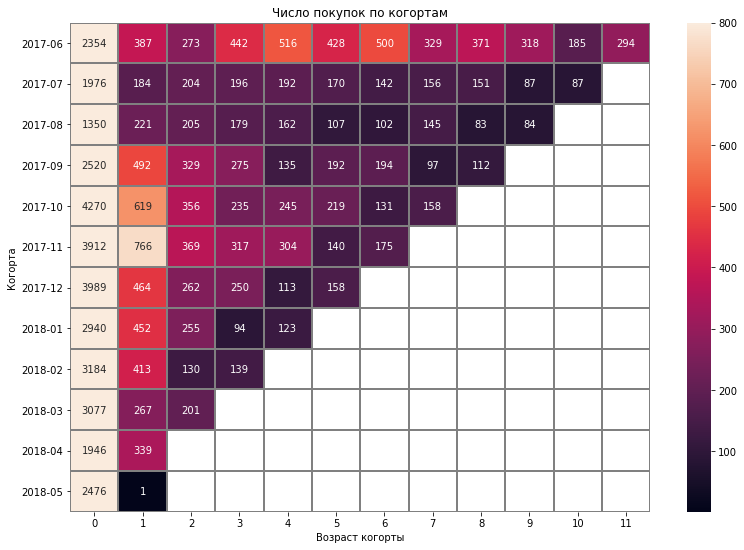

In [59]:
plt.figure(figsize=(13, 9))
sns.heatmap(cohort_purchases, annot=True, fmt='.0f', linewidths=1, linecolor='gray', vmax=800)
plt.title('Число покупок по когортам')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта');

Число покупок в каждой когорте в первый месяц колеблется в основном от 2 до 4 тысяч, с минимумом (1350) в августе и максимальными значениями осенью, что соответствует сезонным тенденциям, отмеченным ранее. Наибольшее число покупок пользователи всех когорт совершают в нулевой месяц, затем количество покупок снижается до примерно 100. Отличается опять же первая когорта, у которой в районе 4-6 месяца число покупок выросло в сравнении с 1-3 месяцами (хотя по-прежнему даже не приблизилось к числу в нулевой месяц), что, возможно, объясняется сезонностью. Кроме того, в этой когорте через год ее существования число пользоватетей остается очень большим (около 300 человек), сопоставимым с числом пользователей в апрельской когорте на ее втором месяце. Отметим также, что по числу покупок лидирующий в остальных отношениях ноябрь находится на третьем месте, после октября и декабря.

In [60]:
cohort_amount = cohort_orders.pivot_table(index=['cohort', 'age'], 
                                                  aggfunc={'revenue': 'sum', 'user_id': 'nunique'}).reset_index()
cohort_amount['average_purchase'] = cohort_amount['revenue'] / cohort_amount['user_id']

In [61]:
cohort_average_amount = cohort_amount.pivot_table(index='cohort', columns='age',
                                                         values='average_purchase')

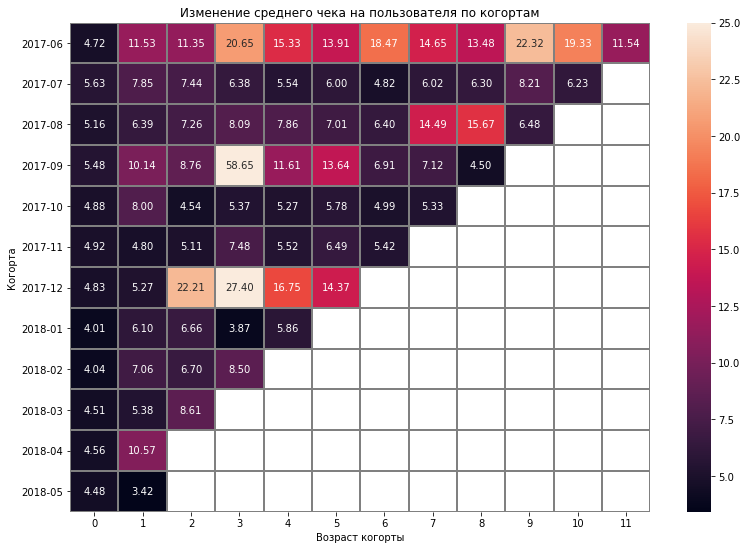

In [62]:
plt.figure(figsize=(13, 9))
sns.heatmap(cohort_average_amount, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmax=25)
plt.title('Изменение среднего чека на пользователя по когортам')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта');

Средний чек в первый месяц существования большинства когорт составляет примерно 4-5 тыс. рублей. Затем в большей части когорт он увеличивается на второй-третий месяц. По этому наблюдению сложно однозначно заключить, склонны ли пользователи начинать покупки на 2-3 месяце пользования сервисом или к этому времени остаются те, кто покупал изначально (скорее, второе). Отметим стабильный относительно высокий средний чек (больше 10 начиная со второго месяца) для первой когорты на всем периоде ее существования, а также очень высокое значение для сентябрьской когорты в третий месяц (это, по-видимому, декабрьские "выбросы", отмеченные выше). 

In [63]:
cohort_total_amount = cohort_amount.pivot_table(index='cohort', columns='age',
                                                         values='revenue', aggfunc='sum')

Рассчитаем кумулятивную сумму доли от общего дохода с каждой когорты по месяцам.

In [64]:
result = cohort_total_amount.div(cohort_total_amount.sum(axis=1), axis=0)
result.cumsum(axis=1)

age,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-06,0.238782,0.305353,0.341946,0.438935,0.537386,0.607952,0.695144,0.751877,0.809787,0.896772,0.951836,1.0
2017-07,0.554392,0.613862,0.676117,0.731302,0.778853,0.823659,0.856670,0.899916,0.940592,0.973773,1.000000,NaN
2017-08,0.463146,0.537231,0.611615,0.681903,0.742076,0.781662,0.817812,0.910387,0.972090,1.000000,NaN,NaN
2017-09,0.366872,0.476736,0.539398,0.849319,0.887573,0.944280,0.972985,0.987573,1.000000,NaN,NaN,NaN
2017-10,0.659147,0.795908,0.843543,0.881524,0.918981,0.955674,0.976455,1.000000,NaN,NaN,NaN,NaN
2017-11,0.676791,0.785999,0.840973,0.897040,0.942431,0.971400,1.000000,NaN,NaN,NaN,NaN,NaN
2017-12,0.541019,0.596833,0.731576,0.896023,0.942803,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.728476,0.862643,0.942713,0.963740,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.764385,0.896144,0.940177,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


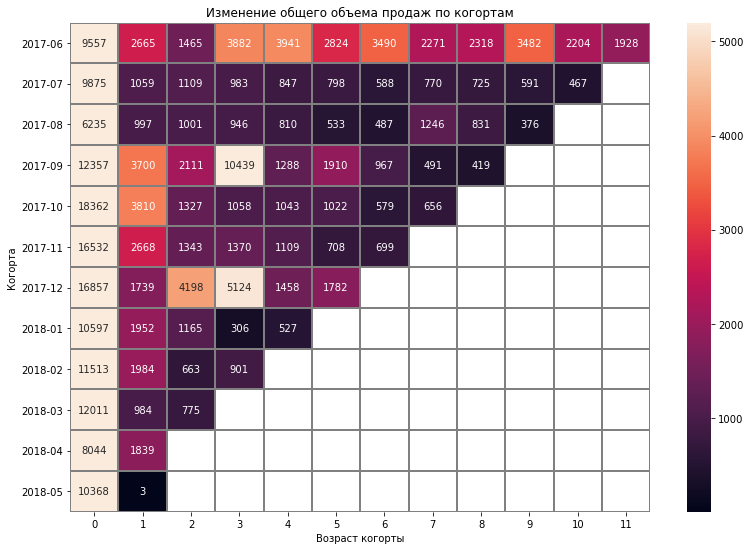

In [65]:
plt.figure(figsize=(13, 9))
sns.heatmap(cohort_total_amount, annot=True, fmt='.0f', linewidths=1, linecolor='gray', vmax=5200)
plt.title('Изменение общего объема продаж по когортам')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта');

Изменения общего объема продаж, скорее, соответствует изменению числа пользователей, чем средних чеков: наибольшие продажи в каждой когорте фиксируются в первый месяц, затем сумма в целом снижается, хотя есть несколько значительных максимумов, в частности, в третий месяц сентябрьской и декабрьской когорты (см. выше про выбросы). И вновь отметим стабильные и относительно высокие показатели первой когорты.

Сравним LTV по когортам.

In [66]:
buyers_cohorts = orders.pivot_table(index='user_id', values='month', aggfunc='min').reset_index().rename(columns={'month': 'cohort'})

In [67]:
buyers_cohorts # когорты покупателей

,user_id,cohort
0,10000837700716403746,2017-06
1,10000997030965831953,2018-01
2,10001199569370567060,2017-11
3,10002243978166172255,2017-10
4,10003351403065971701,2017-11
...,...,...
36518,999745712858219747,2017-08
36519,9997777271989789335,2017-11
36520,999906621142257600,2018-01
36521,9999334409150825432,2017-12


In [68]:
buyers_cohorts = orders[['revenue', 'user_id', 'month']].merge(buyers_cohorts, on='user_id') 
# соединяем когорты с данными о покупках

In [69]:
buyers_cohorts[buyers_cohorts['cohort'] == '2018-05']

,revenue,user_id,month,cohort
47165,2.81,15388785282246108585,2018-05,2018-05
47166,3.30,13799223062808781274,2018-05,2018-05
47167,0.61,11872107117335113332,2018-05,2018-05
47168,3.67,6495034284348196506,2018-05,2018-05
47169,8.55,1821470997306639636,2018-05,2018-05
...,...,...,...,...
50409,3.67,1805512004303848280,2018-05,2018-05
50410,4.64,12296626599487328624,2018-05,2018-05
50411,5.80,11369640365507475976,2018-05,2018-05
50412,0.30,1786462140797698849,2018-05,2018-05


In [70]:
buyers_cohorts['month'] = pd.to_datetime(buyers_cohorts['month'], format='%Y-%m')
buyers_cohorts['first_purchase'] = pd.to_datetime(buyers_cohorts['cohort'], format='%Y-%m')

In [71]:
buyers_cohorts['age'] = ((buyers_cohorts['month'] - buyers_cohorts['first_purchase']) 
                           / np.timedelta64(1, 'M')).round().astype(int) 
# месяц покупки в возрасте когорты

In [72]:
buyers_cohorts[buyers_cohorts['cohort'] == '2018-05']

,revenue,user_id,month,cohort,first_purchase,age
47165,2.81,15388785282246108585,2018-05-01,2018-05,2018-05-01,0
47166,3.30,13799223062808781274,2018-05-01,2018-05,2018-05-01,0
47167,0.61,11872107117335113332,2018-05-01,2018-05,2018-05-01,0
47168,3.67,6495034284348196506,2018-05-01,2018-05,2018-05-01,0
47169,8.55,1821470997306639636,2018-05-01,2018-05,2018-05-01,0
...,...,...,...,...,...,...
50409,3.67,1805512004303848280,2018-05-01,2018-05,2018-05-01,0
50410,4.64,12296626599487328624,2018-05-01,2018-05,2018-05-01,0
50411,5.80,11369640365507475976,2018-05-01,2018-05,2018-05-01,0
50412,0.30,1786462140797698849,2018-05-01,2018-05,2018-05-01,0


In [73]:
cohort_total_users = buyers_cohorts.groupby('cohort').agg({'user_id': 'nunique'}).reset_index()

In [74]:
cohort_total_users # число уникальных пользователей - численность каждой когорты

,cohort,user_id
0,2017-06,2023
1,2017-07,1923
2,2017-08,1370
3,2017-09,2581
4,2017-10,4340
5,2017-11,4081
6,2017-12,4383
7,2018-01,3373
8,2018-02,3651
9,2018-03,3533


In [75]:
buyers_cohorts = buyers_cohorts.groupby(['cohort', 'age']).agg({'revenue': 'sum'}).reset_index()
buyers_cohorts = buyers_cohorts.merge(cohort_total_users, on='cohort')
buyers_cohorts['ltv'] = buyers_cohorts['revenue'] / buyers_cohorts['user_id'] 

In [76]:
buyers_cohorts_pivot = buyers_cohorts.pivot_table(index='cohort', columns='age', values = 'ltv')
buyers_cohorts_pivot 

age,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-06,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.141820,0.161232,0.147145,0.155673,NaN
2017-08,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540,0.210664,0.405007,0.292212,0.187978,NaN,NaN
2017-09,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067,0.701608,0.243150,0.184006,NaN,NaN,NaN
2017-10,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816,0.115470,NaN,NaN,NaN,NaN
2017-11,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,NaN,NaN,NaN,NaN,NaN
2017-12,4.738191,0.260374,0.925097,1.065275,0.312930,0.338047,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.135636,0.294758,0.304281,0.142778,0.062698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.156987,0.278274,0.078515,0.074144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


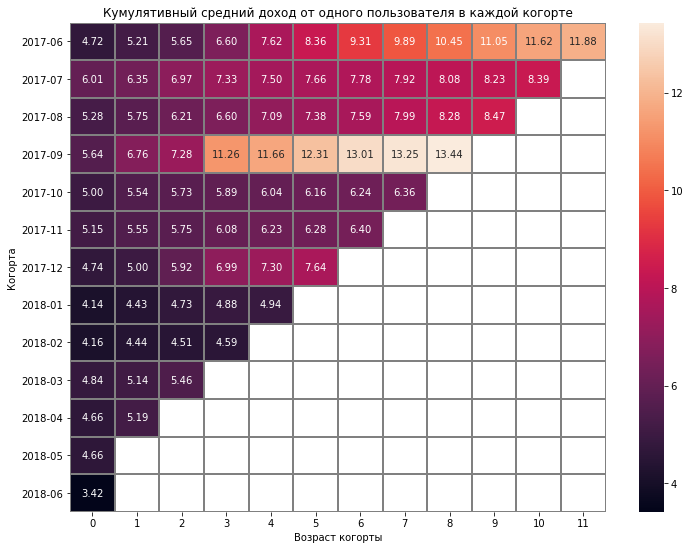

In [77]:
plt.figure(figsize=(12, 9))
sns.heatmap(buyers_cohorts_pivot.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('Кумулятивный средний доход от одного пользователя в каждой когорте')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта');

In [78]:
buyers_cohorts_pivot['ltv'] = buyers_cohorts_pivot.sum(axis=1)
cohort_ltv = buyers_cohorts_pivot['ltv']
cohort_ltv

cohort
2017-06    11.879234
2017-07     8.386854
2017-08     8.471723
2017-09    13.435227
2017-10     6.360242
2017-11     6.395244
2017-12     7.639913
2018-01     4.940151
2018-02     4.587921
2018-03     5.455253
2018-04     5.189196
2018-05     4.660562
2018-06     3.420000
Name: ltv, dtype: float64

Наиболее высокий показатель LTV имеет сентябрьская когорта, за ней следует июньская - наиболее старая, но также сохраняющая высокие показатели на всем протяжении своего существования. Высокие показатели LTV у сентябрьской когорты, вероятно, следует объяснять высокими доходами в нулевой месяц, который, как мы видели выше, в значительно мере определяют суммарный доход с когорт, кроме того, пользователи из этой когорты совершили несколько крайне дорогих покупок. Сранительно небольшой LTV имеет самая многочисленная - ноябрьская - когорта, проигрывающая по этому показателю следующей за ней декабрьской когорте, несмотря на больший срок жизни. Относительно высокий LTV декабрьской когорты, за 6 месяцев почти догнавшей июльскую и августовскую, следует объяснять, по-видимому, большим количеством продаж около нового года, а также несколькими крайне дорогими покупками входящих в нее пользователей.

[Наверх](#contents)

### C. Анализ маркетинговых расходов <a id='marketing'></a>

#### Структура маркетинговых расходов

In [79]:
f'Суммарные маркетинговые расходы составляют {costs.costs.sum()}'

'Суммарные маркетинговые расходы составляют 329131.62'

,costs
month,
2017-06,18015.00
2017-07,18240.59
2017-08,14790.54
2017-09,24368.91
2017-10,36322.88
2017-11,37907.88
2017-12,38315.35
2018-01,33518.52
2018-02,32723.03


,costs
count,12.000000
mean,27427.635000
std,8405.071207
min,14790.540000
25%,21228.350000
50%,27392.090000
75%,34219.610000
max,38315.350000


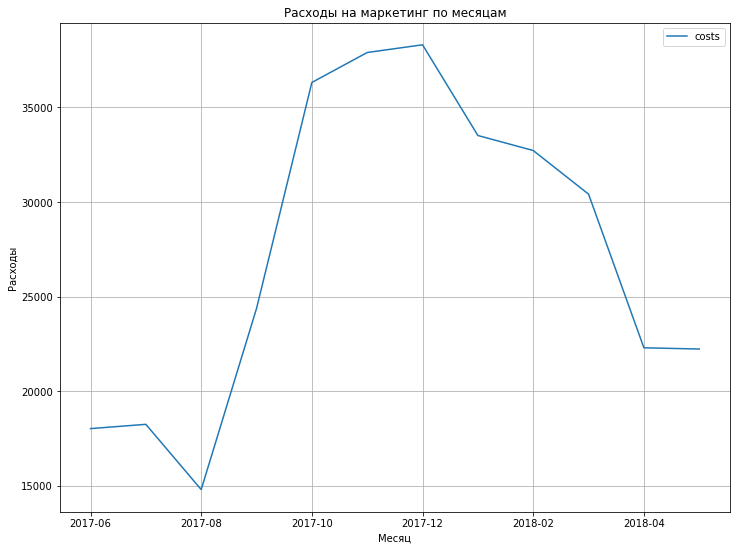

In [80]:
costs['month'] = costs['date'].dt.strftime('%Y-%m')
marketing_by_month = costs.groupby('month').agg({'costs': 'sum'})
display(marketing_by_month)
line_plot(marketing_by_month, title='Расходы на маркетинг по месяцам', xlabel='Месяц', ylabel='Расходы')

,costs
source_id,
1,20833.27
10,5822.49
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49


,costs
count,7.000000
mean,47018.802857
std,46967.961870
min,5517.490000
25%,13327.880000
50%,42806.040000
75%,56415.350000
max,141321.630000


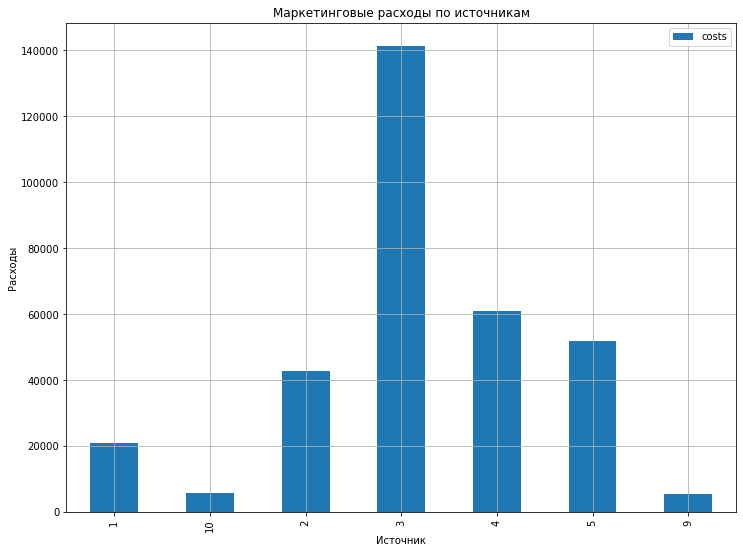

In [81]:
marketing_by_source = costs.groupby('source_id').agg({'costs': 'sum'})
display(marketing_by_source)
display(marketing_by_source.describe())
marketing_by_source.plot(kind='bar', grid=True, figsize=(12,9))
plt.title('Маркетинговые расходы по источникам')
plt.xlabel('Источник')
plt.ylabel('Расходы');

Маркетинговые расходы за прошедший год составили 329 млн. рублей, почти половина (141 млн.) приходится на источник 3, примерно столько же - на три следующих источника, наименьшие расходы - на источники 9 и 10. Расходы очень сильно отличаются по месяцам: самые затратные месяцы - декабрь, ноябрь и октябрь. Меньше всего денег тратится на маркетинг в августе, наименее "активном" месяце, общая динамика маркетинговых расходов в основном соответствует динамике пользовательской активности. Рассчитаем эффективность маркетинговых расходов. 

#### Расчет CAC и ROMI по месяцам

In [82]:
cohort_orders

,purchase_time,revenue,user_id,month,cohort,first_visit,age
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06,2017-06-01,0
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2017-10,2017-10-01,7


In [83]:
buyers_per_month = cohort_orders.pivot_table(index=['cohort', 'age'], aggfunc={'user_id': 'nunique'}).reset_index()
marketing_by_month = marketing_by_month.reset_index().rename(columns={'month': 'cohort'})
cac = buyers_per_month[buyers_per_month['age'] == 0].merge(marketing_by_month, on='cohort')
cac['cac'] = cac['costs'] / cac['user_id']

In [84]:
cac

,cohort,age,user_id,costs,cac
0,2017-06,0,2023,18015.00,8.905091
1,2017-07,0,1753,18240.59,10.405357
2,2017-08,0,1208,14790.54,12.243825
3,2017-09,0,2257,24368.91,10.797036
4,2017-10,0,3761,36322.88,9.657772
5,2017-11,0,3357,37907.88,11.292189
6,2017-12,0,3491,38315.35,10.975465
7,2018-01,0,2644,33518.52,12.677201
8,2018-02,0,2852,32723.03,11.473713
9,2018-03,0,2663,30415.27,11.421431


In [85]:
month_romi = cohort_amount.merge(cac[['cohort', 'cac']], on='cohort')
month_romi['romi'] = month_romi['average_purchase'] / month_romi['cac']

In [86]:
output = month_romi.pivot_table(index='cohort', columns='age', aggfunc={'romi': 'sum'})
output.cumsum(axis=1).round(2)

romi                                                             \
age        0     1     2     3     4      5      6      7      8      9    
cohort                                                                     
2017-06  0.53  1.83  3.10  5.42  7.14   8.70  10.78  12.42  13.94  16.44   
2017-07  0.54  1.30  2.01  2.62  3.16   3.73   4.20   4.77   5.38   6.17   
2017-08  0.42  0.94  1.54  2.20  2.84   3.41   3.93   5.12   6.40   6.93   
2017-09  0.51  1.45  2.26  7.69  8.76  10.03  10.67  11.33  11.74    NaN   
2017-10  0.51  1.33  1.80  2.36  2.91   3.50   4.02   4.57    NaN    NaN   
2017-11  0.44  0.86  1.31  1.98  2.46   3.04   3.52    NaN    NaN    NaN   
2017-12  0.44  0.92  2.94  5.44  6.97   8.28    NaN    NaN    NaN    NaN   
2018-01  0.32  0.80  1.32  1.63  2.09    NaN    NaN    NaN    NaN    NaN   
2018-02  0.35  0.97  1.55  2.29   NaN    NaN    NaN    NaN    NaN    NaN   
2018-03  0.39  0.87  1.62   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
2018-04  0.36  1.20   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
2018-05  0.47  0.82   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   

                       
age         10     11  
cohort                 
2017-06  18.61  19.91  
2017-07   6.77    NaN  
2017-08    NaN    NaN  
2017-09    NaN    NaN  
2017-10    NaN    NaN  
2017-11    NaN    NaN  
2017-12    NaN    NaN  
2018-01    NaN    NaN  
2018-02    NaN    NaN  
2018-03    NaN    NaN  
2018-04    NaN    NaN  
2018-05    NaN    NaN

In [87]:
print('Средний показатель ROMI')
output.cumsum(axis=1).mean(axis=0)

Средний показатель ROMI


      age
romi  0       0.439367
      1       1.106350
      2       1.945995
      3       3.514060
      4       4.541094
      5       5.813788
      6       6.185964
      7       7.643141
      8       9.364470
      9       9.846157
      10     12.690332
      11     19.909630
dtype: float64

В среднем привлечение одного пользователя окупается на второй месяц.

#### Расчет CAC и ROMI по источникам трафика

In [88]:
# отбираем для каждого пользователя дату первого визита
user_source = visits.pivot_table(index='user_id', aggfunc={'start_session': 'min'}).reset_index()

In [89]:
# присоединяем месяц и источник
user_source = user_source.merge(visits[['user_id', 'start_session', 'month', 'source_id']], 
                               on=['user_id', 'start_session'], how='left')[['user_id', 'month', 'source_id']]

In [90]:
user_source # каждому пользователю соответствует источник, откуда он пришел в первый раз

,user_id,month,source_id
0,10000171586432207426,2017-12,3
1,10000344846682484395,2018-02,3
2,1000036778515242839,2017-09,3
3,10000460875579931334,2017-09,4
4,10000558740593440652,2018-01,4
...,...,...,...
228165,9999530179466660745,2017-06,3
228166,9999704916412649026,2017-06,4
228167,9999829453910784044,2017-11,3
228168,9999912853550499774,2017-08,4


In [91]:
user_source.groupby('user_id').agg({'source_id': 'count'}).sort_values(by='source_id', ascending=False)

,source_id
user_id,
1981020429381477763,2
4469492126122745634,1
4466885703736860738,1
4467028035626591815,1
4467191070398146845,1
...,...
15534042754764577993,1
15534134368299596188,1
15534178357572285229,1


In [92]:
visits[visits['user_id'] == '1981020429381477763']
# в таблице два раза учтен единственный юзер, у которого старт двух сессий совпадает до секунды, возможно, из-за каких-то
# технических особенностей сбора логов, но он едва ли сильно повлияет на CAC

,device,end_session,source_id,start_session,user_id,week,month,date,year,duration
44993,touch,2018-03-16 08:57:00,1,2018-03-16 08:55:00,1981020429381477763,2018-11,2018-03,2018-03-16,2018,120
47067,touch,2018-03-16 08:55:00,1,2018-03-16 08:55:00,1981020429381477763,2018-11,2018-03,2018-03-16,2018,0


In [93]:
# суммируем количество пользователей для каждого источника в каждый месяц
user_by_source_month = user_source.pivot_table(index=['month', 'source_id'], 
                                               aggfunc={'user_id': 'count'}).reset_index()
# суммируем маркетинговые расходы для каждого источника в каждый месяц
marketing_source_month = costs.pivot_table(index=['month', 'source_id'], 
                                           aggfunc={'costs': 'sum'}).reset_index()

In [94]:
# объединяем количество пользователей и маркетинговые расходы
user_by_source_month = user_by_source_month.merge(marketing_source_month,
                                                 on=['month', 'source_id'])

In [95]:
# делим маркетинговые расходы на количество пользователей (по каждому источнику в каждый месяц)
user_by_source_month['cac'] = user_by_source_month['costs'] / user_by_source_month['user_id']

In [96]:
user_by_source_month # получаем CAC

,month,source_id,user_id,costs,cac
0,2017-06,1,631,1125.61,1.783851
1,2017-06,10,396,314.22,0.793485
2,2017-06,2,1262,2427.38,1.923439
3,2017-06,3,4080,7731.65,1.895012
4,2017-06,4,3447,3514.80,1.019669
...,...,...,...,...,...
79,2018-05,2,1545,2689.44,1.740738
80,2018-05,3,3836,9411.42,2.453446
81,2018-05,4,5278,4214.21,0.798448
82,2018-05,5,2972,3669.56,1.234711


Итак, у нас есть сводка маркетинговых расходов, а также число привлеченных пользователей и CAC по источникам в каждый месяц. Построим графики динамики CAC по источникам и месяцам.

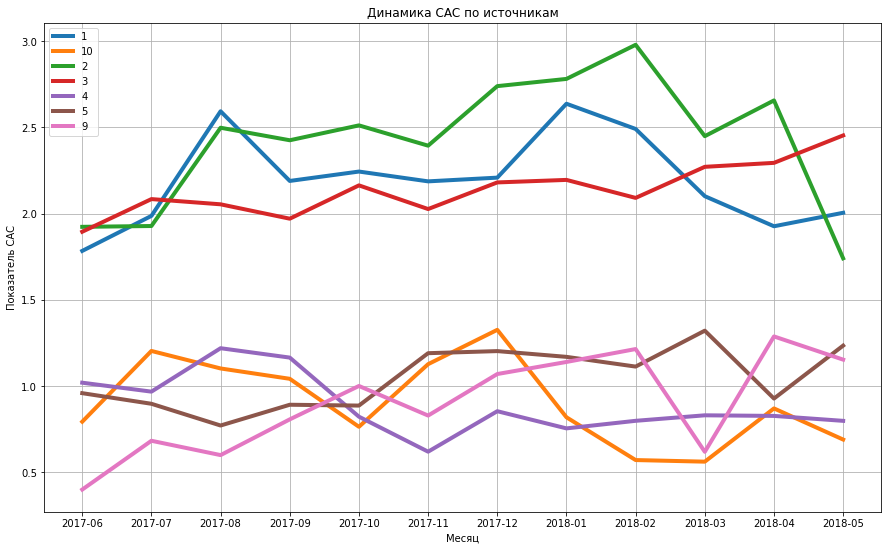

In [97]:
sources = user_by_source_month['source_id'].unique()

fig = plt.figure(figsize=(15,9))
ax = plt.axes()
for source in sources:
    plt.plot(user_by_source_month.query('source_id == @source')['month'], 
             user_by_source_month.query('source_id == @source')['cac'], 
             linewidth=4)
plt.grid(b=True)
plt.title('Динамика CAC по источникам')
plt.ylabel('Показатель CAC')
plt.xlabel('Месяц')
plt.legend(sources);

Таким образом, у нас есть три источника с относительно высокой ценой привлечения пользователей (1, 2, 3) - 1.5-3 тыс. рублей - и четыре источника с относительно низкой CAC - от 0.5 до 1.5. Добавим к данным LTV и рассчитаем ROMI для каждого источника.

In [98]:
cohort_ltv = cohort_ltv.reset_index().rename(columns={'cohort': 'month'})

План расчета ROMI:  
1. Мерджим к каждой покупке месяц первой покупки и источник, который привлек пользователя, - это моя таблица `user_source`.
2. Считаем месяц каждой покупки относительно прихода пользователя - это будет покупка в возрасте когорты.
3. Объединяем доход и число уникальных пользователей по когорте, источнику и месяцу в возрасте когоргы одновременно.
4. Делим доход на число уникальных пользователей - получается доход от одного пользователя из каждого источника в каждый месяц жизни когорты.
5. Добавляем маркетинговые расходы по источникам и месяцам.
6. Суммируем средний доход по когортам - получаем LTV по источникам и месяцу первого визита, считаем CAC по месяцам и источникам, делим одно на другое - получаем ответ, насколько окупились средства, которые мы каждый месяц инвестировали в каждый источник на одного пользователя.
6. Рассчитываем для каждого из шести источников накопительную сумму по месяцам, смотрим на результаты.

In [99]:
first_purchase = orders.groupby('user_id').agg({'purchase_time': 'min'}).reset_index()
first_purchase['cohort'] = first_purchase['purchase_time'].dt.strftime('%Y-%m')
first_purchase = first_purchase.merge(user_source[['user_id', 'source_id']], on='user_id')
first_purchase
# таблица с когортами и источниками по дате первой покупки

,user_id,purchase_time,cohort,source_id
0,10000837700716403746,2017-06-21 16:12:00,2017-06,4
1,10000997030965831953,2018-01-19 12:28:00,2018-01,4
2,10001199569370567060,2017-11-25 17:29:00,2017-11,4
3,10002243978166172255,2017-10-15 17:20:00,2017-10,4
4,10003351403065971701,2017-11-20 13:18:00,2017-11,4
...,...,...,...,...
36518,999745712858219747,2017-08-08 17:53:00,2017-08,3
36519,9997777271989789335,2017-11-17 16:36:00,2017-11,3
36520,999906621142257600,2018-01-26 22:16:00,2018-01,2
36521,9999334409150825432,2017-12-06 13:28:00,2017-12,3


In [100]:
buyers_source_monthly = orders.merge(first_purchase[['user_id', 'cohort', 'source_id']], on='user_id')

In [101]:
buyers_source_monthly['month'] = pd.to_datetime(buyers_source_monthly['month'], format='%Y-%m')
buyers_source_monthly['first_purchase'] = pd.to_datetime(buyers_source_monthly['cohort'], format='%Y-%m')
buyers_source_monthly['age'] = ((buyers_source_monthly['month'] - buyers_source_monthly['first_purchase']) 
                           / np.timedelta64(1, 'M')).round().astype(int) 

In [102]:
buyers_source_monthly = buyers_source_monthly.pivot_table(index=['cohort', 'source_id', 'age'],
                                                         aggfunc={'revenue': 'sum', 'user_id': 'nunique'}).reset_index()

In [103]:
buyers_source_monthly = buyers_source_monthly.rename(columns={'cohort': 'month'})

In [104]:
buyers_source_monthly = buyers_source_monthly.merge(marketing_source_month,
                                                 on=['month', 'source_id'])

In [105]:
buyers_source_monthly 
# таблица с когортами, доходами и маркетинговыми расходами на каждый источник

,month,source_id,age,revenue,user_id,costs
0,2017-06,1,0,1378.70,190,1125.61
1,2017-06,1,1,414.98,16,1125.61
2,2017-06,1,2,419.43,10,1125.61
3,2017-06,1,3,714.24,9,1125.61
4,2017-06,1,4,811.20,12,1125.61
...,...,...,...,...,...,...
509,2018-05,2,0,2820.14,412,2689.44
510,2018-05,3,0,3256.54,844,9411.42
511,2018-05,4,0,3802.91,804,4214.21
512,2018-05,5,0,2094.04,497,3669.56


In [106]:
zero_age_buyers = buyers_source_monthly[buyers_source_monthly['age'] == 0][['user_id', 'month', 'source_id']]
zero_age_buyers = zero_age_buyers.rename(columns={'user_id': 'zero_age_buyers'})

In [107]:
zero_age_buyers # выделяем численность каждой когорты - число уникальных пользователей в нулевой месяц для каждого источника

,zero_age_buyers,month,source_id
0,190,2017-06,1
12,95,2017-06,10
15,235,2017-06,2
27,638,2017-06,3
39,413,2017-06,4
...,...,...,...
509,412,2018-05,2
510,844,2018-05,3
511,804,2018-05,4
512,497,2018-05,5


In [108]:
cac = buyers_source_monthly[buyers_source_monthly['age'] == 0]

In [109]:
cac['cac'] = cac['costs'] / cac['user_id']

In [110]:
cac

,month,source_id,age,revenue,user_id,costs,cac
0,2017-06,1,0,1378.70,190,1125.61,5.924263
12,2017-06,10,0,229.35,95,314.22,3.307579
15,2017-06,2,0,1043.68,235,2427.38,10.329277
27,2017-06,3,0,2804.34,638,7731.65,12.118574
39,2017-06,4,0,1959.84,413,3514.80,8.510412
...,...,...,...,...,...,...,...
509,2018-05,2,0,2820.14,412,2689.44,6.527767
510,2018-05,3,0,3256.54,844,9411.42,11.150972
511,2018-05,4,0,3802.91,804,4214.21,5.241555
512,2018-05,5,0,2094.04,497,3669.56,7.383421


In [111]:
buyers_source_monthly = buyers_source_monthly.merge(cac[['month', 'source_id', 'cac']], on=['month', 'source_id'])
buyers_source_monthly = buyers_source_monthly.merge(zero_age_buyers[['month', 'source_id', 'zero_age_buyers']], on=['month', 'source_id'])

In [112]:
buyers_source_monthly

,month,source_id,age,revenue,user_id,costs,cac,zero_age_buyers
0,2017-06,1,0,1378.70,190,1125.61,5.924263,190
1,2017-06,1,1,414.98,16,1125.61,5.924263,190
2,2017-06,1,2,419.43,10,1125.61,5.924263,190
3,2017-06,1,3,714.24,9,1125.61,5.924263,190
4,2017-06,1,4,811.20,12,1125.61,5.924263,190
...,...,...,...,...,...,...,...,...
509,2018-05,2,0,2820.14,412,2689.44,6.527767,412
510,2018-05,3,0,3256.54,844,9411.42,11.150972,844
511,2018-05,4,0,3802.91,804,4214.21,5.241555,804
512,2018-05,5,0,2094.04,497,3669.56,7.383421,497


In [113]:
buyers_source_monthly['ltv'] = buyers_source_monthly['revenue'] / buyers_source_monthly['zero_age_buyers']
buyers_source_monthly['romi'] = buyers_source_monthly['ltv'] / buyers_source_monthly['cac']
buyers_source_monthly # в таблице есть все основные метрики

,month,source_id,age,revenue,user_id,costs,cac,zero_age_buyers,ltv,romi
0,2017-06,1,0,1378.70,190,1125.61,5.924263,190,7.256316,1.224847
1,2017-06,1,1,414.98,16,1125.61,5.924263,190,2.184105,0.368671
2,2017-06,1,2,419.43,10,1125.61,5.924263,190,2.207526,0.372625
3,2017-06,1,3,714.24,9,1125.61,5.924263,190,3.759158,0.634536
4,2017-06,1,4,811.20,12,1125.61,5.924263,190,4.269474,0.720676
...,...,...,...,...,...,...,...,...,...,...
509,2018-05,2,0,2820.14,412,2689.44,6.527767,412,6.845000,1.048597
510,2018-05,3,0,3256.54,844,9411.42,11.150972,844,3.858460,0.346020
511,2018-05,4,0,3802.91,804,4214.21,5.241555,804,4.729988,0.902402
512,2018-05,5,0,2094.04,497,3669.56,7.383421,497,4.213360,0.570652


In [114]:
# средний показатель ROMI для каждого источника
buyers_source_monthly.groupby(['source_id', 'month']).agg({'romi': 'sum'}).reset_index().groupby('source_id').agg({'romi': 'mean'})

,romi
source_id,
1,1.733219
10,0.769279
2,1.074434
3,0.393899
4,0.937881
5,1.120739
9,1.089883


In [115]:
# считаем окупаемость по возрасту когорты для каждого источника
for source in ['1', '2', '3', '4', '5', '9', '10']:
    output = buyers_source_monthly.loc[buyers_source_monthly['source_id'] == source].pivot_table(index='month', 
                                                        columns='age', values='romi').cumsum(axis=1)
    print()
    print(f'ROMI по когортам для источника {source}')
    display(output)


ROMI по когортам для источника 1


age,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
2017-06,1.224847,1.593518,1.966143,2.600679,3.321355,3.667247,4.102993,4.528744,4.912670,5.193673,5.397047,5.679045
2017-07,1.087447,1.250848,2.049390,2.274131,2.405115,2.539315,2.605958,2.702315,2.830130,2.977080,3.115465,NaN
2017-08,0.889621,1.031761,1.151700,1.266240,1.389626,1.468739,1.549490,1.864952,2.125330,2.217785,NaN,NaN
2017-09,0.909009,1.181317,1.265844,1.405616,1.411475,1.425883,1.438725,1.485103,1.574257,NaN,NaN,NaN
2017-10,0.883658,1.038674,1.074611,1.131551,1.140840,1.156727,1.183642,1.230737,NaN,NaN,NaN,NaN
2017-11,0.979343,1.055375,1.183056,1.301506,1.323140,1.337180,1.347875,NaN,NaN,NaN,NaN,NaN
2017-12,0.648129,0.692102,0.732928,0.767666,0.771425,0.784944,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.628027,0.637880,0.653615,0.759581,0.764946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.584628,0.709355,0.717757,0.763854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



ROMI по когортам для источника 2


age,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
2017-06,0.429962,0.477560,0.503885,0.690238,0.851605,0.940574,1.095688,1.239176,1.368451,1.439482,1.571011,1.612957
2017-07,0.751516,0.819768,0.825058,0.853745,0.892273,0.908877,0.935520,0.947735,0.957640,0.978059,1.010484,NaN
2017-08,0.389763,0.453328,0.465437,0.482477,0.517462,0.521747,0.530013,0.556710,0.558963,0.564695,NaN,NaN
2017-09,0.613054,1.214726,1.389596,1.457926,1.562160,1.634325,1.879913,1.935676,1.976551,NaN,NaN,NaN
2017-10,0.627418,0.828147,0.882153,0.926289,0.971756,0.993527,1.001674,1.022289,NaN,NaN,NaN,NaN
2017-11,0.530093,0.599000,0.632190,0.691618,0.715369,0.726229,0.737183,NaN,NaN,NaN,NaN,NaN
2017-12,0.685251,0.805237,1.531100,2.394593,2.631477,2.881190,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.305034,0.381590,0.503596,0.520783,0.543889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.354732,0.397127,0.418290,0.435030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



ROMI по когортам для источника 3


age,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
2017-06,0.362709,0.372018,0.387400,0.413080,0.428404,0.444349,0.454904,0.457347,0.461477,0.465854,0.468178,0.470834
2017-07,0.407306,0.424837,0.433096,0.459381,0.462048,0.466784,0.469219,0.478039,0.483650,0.486372,0.490078,NaN
2017-08,0.278585,0.287076,0.302871,0.308739,0.317628,0.320332,0.323867,0.328954,0.333270,0.336612,NaN,NaN
2017-09,0.436067,0.455488,0.480923,0.487788,0.505335,0.514671,0.524655,0.530458,0.539898,NaN,NaN,NaN
2017-10,0.350405,0.383851,0.392568,0.397133,0.405064,0.412022,0.413351,0.418730,NaN,NaN,NaN,NaN
2017-11,0.323720,0.333349,0.339364,0.347794,0.351757,0.354019,0.356397,NaN,NaN,NaN,NaN,NaN
2017-12,0.339316,0.350023,0.361562,0.371804,0.379808,0.384783,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.279503,0.291865,0.300848,0.306240,0.309861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.290698,0.314463,0.321232,0.325942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



ROMI по когортам для источника 4


age,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
2017-06,0.557596,0.562336,0.582414,0.636398,0.771341,0.946290,1.114240,1.141630,1.167076,1.261389,1.410496,1.420471
2017-07,0.812139,0.820794,0.832579,0.856043,0.864239,0.873359,0.888312,0.894941,0.907661,0.916589,0.919793,NaN
2017-08,0.532101,0.549820,0.563574,0.591640,0.607010,0.628944,0.637681,0.657592,0.667336,0.680281,NaN,NaN
2017-09,0.541641,0.596259,0.631879,0.664614,0.670267,0.697217,0.839790,0.869970,0.875832,NaN,NaN,NaN
2017-10,0.797284,0.823925,0.851565,0.871950,0.893710,0.910554,0.926587,0.938349,NaN,NaN,NaN,NaN
2017-11,1.123482,1.264895,1.286849,1.375425,1.417895,1.427450,1.475637,NaN,NaN,NaN,NaN,NaN
2017-12,0.747976,0.763990,0.780472,0.795830,0.802966,0.818265,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.669090,0.690412,0.705098,0.718061,0.723333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.792597,0.813924,0.820739,0.824323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



ROMI по когортам для источника 5


age,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
2017-06,0.725842,0.858378,0.924327,1.052429,1.149791,1.193493,1.326380,1.412554,1.494515,1.633308,1.656212,1.673333
2017-07,0.745866,0.790947,0.855107,0.876734,0.890415,0.905635,0.909364,0.924940,0.937978,0.945997,0.956550,NaN
2017-08,0.831953,0.955873,1.092899,1.209918,1.387786,1.485746,1.549188,1.589751,1.628922,1.667562,NaN,NaN
2017-09,0.948191,0.976112,1.026832,3.500868,3.619115,3.927979,3.970851,4.001546,4.004988,NaN,NaN,NaN
2017-10,0.834182,0.870729,0.890452,0.910457,0.929032,0.945010,0.968603,0.989198,NaN,NaN,NaN,NaN
2017-11,0.499633,0.520148,0.533050,0.539127,0.554143,0.558520,0.570403,NaN,NaN,NaN,NaN,NaN
2017-12,0.657360,0.675128,0.686937,0.694128,0.696684,0.697736,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.512827,0.573910,0.619229,0.622958,0.626210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.577786,0.590126,0.596305,0.597625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



ROMI по когортам для источника 9


age,0,1,2,3,4,5,6,7,8,9,10
month,,,,,,,,,,,
2017-06,0.850887,0.867997,1.008169,1.152935,1.216710,1.322242,1.449057,1.478613,1.606795,1.636105,1.655389
2017-07,0.768130,0.795300,0.903153,0.986613,1.049845,1.060422,1.109506,1.119587,1.193594,1.197627,1.210352
2017-08,0.998554,1.047162,1.204154,1.260796,1.274053,1.290684,1.324067,1.395252,1.415137,1.451974,NaN
2017-09,0.899500,1.113565,1.245368,1.413455,1.538713,1.565589,1.694408,1.833742,2.024012,NaN,NaN
2017-10,1.046963,1.158678,1.249323,1.273379,1.332945,1.444955,1.448581,1.452487,NaN,NaN,NaN
2017-11,0.793671,0.821936,0.856875,0.917723,0.949603,0.956219,0.960684,NaN,NaN,NaN,NaN
2017-12,0.703562,0.761315,0.793064,0.842047,0.846500,0.873416,NaN,NaN,NaN,NaN,NaN
2018-01,0.414394,0.446250,0.475747,0.481194,0.484538,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.731224,0.757570,0.769139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



ROMI по когортам для источника 10


age,0,1,2,3,4,5,6,7,8,9
month,,,,,,,,,,
2017-06,0.729903,0.765101,NaN,NaN,NaN,NaN,NaN,NaN,0.767806,NaN
2017-07,0.535231,0.540052,NaN,0.563186,NaN,NaN,NaN,NaN,0.564308,NaN
2017-08,0.795029,0.812874,0.865417,NaN,NaN,NaN,NaN,0.885110,NaN,0.899557
2017-09,0.417066,0.429136,0.444505,0.480170,0.485467,NaN,NaN,0.487312,0.491957,NaN
2017-10,0.872569,0.900341,0.903753,0.909397,0.922151,0.925403,0.932036,0.949365,NaN,NaN
2017-11,0.746618,0.755086,0.757396,0.787407,0.804319,0.812345,0.821205,NaN,NaN,NaN
2017-12,0.498916,0.516892,NaN,NaN,NaN,0.524464,NaN,NaN,NaN,NaN
2018-01,0.464084,0.466363,0.476813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.632736,0.662390,0.663409,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В среднем за весь период у нас окупаются инвестиции в источники 1 (на 73% - лучший результат), 2, 5 и 9 - каждый из последних примерно на 10%. Источник 1 также окупается быстрее всех, уже на второй месяц он почти всегда приносит прибыль. Три других из эффективных источников окупаются дольше - как правило, ко 2-3 месяцу. Худший результат - у источника 3, он окупается меньше чем на 40%.

[Наверх](#contents)

# 3. Общий вывод <a id='conclusion'></a>

1. Посещаемость сайта очень сильно зависит от сезона: в августе наблюдается спад, в сентябре активность пользователей растет примерно в 1.5-1.8 раза, а пиковые значения в ноябре превышают августовские почти втрое, после чего они постепенно снижаются примернов полтора раза к марту, а затем достаточно резко падает к лету. Аналогичным образом меняется и количество новых пользователей. Соответственно, основные усилися по привлечению пользователей следует прилагать с сентября по март (это, впрочем, и так делается), особенно в районе Нового года, когда средний чек велик.
2. Средний чек за весь период составляет примерно 5 тысяч рублей, при этом он также меняется в зависимости от сезона, однако минимальное значение приходится на январь (чуть больше 4 тысяч), тогда как максимум – на декабрь (5.85 тысячи). В самом популярном месяце – ноябре – средний чек ниже среднего, вероятно из-за большого числа покупок со скидкой.
3. Примерно три четверти пользователей пользуются ПК, остальные - мобильными платформами. Принципиальных различий в поведении пользователей разных платформ не выявлено, для анализа ROMI по платформам недостаточно данных (нет данных о маркетинговых расходах для разных платформ).
4. Большинство пользователей не задерживаются на сайте – значение retention rate в первый месяц ни для одной когорты не превышает 9%, большая часть дохода в каждой когорте (23% с самой старой когорте и около половины в среднем) также генерируется за счет покупок в первый месяц использования сайта. Хотя у тех, кто пользуется нашими услугами больше месяца (и, скорее, даже больше двух) месяцев, средний чек выше (примерно в полтора-два раза, чем в первый месяц), целесообразно направить усилия прежде всего на привлечение новых пользователей.
4. Маркетинговые акции, особенно в ноябре и декабре в целом эффективны, в эти месяцы наблюдается рост активности, которая, впрочем, не всегда напрямую конвертируется в прибыль: так, "черная пятница" привлекает беспрецедентно много новых пользователей, однако при этом, как уже отмечалось средний чек каждого из них ниже среднего.
5. Распределение рекламного бюджета по источникам представляется не вполне оптимальным. Больше всего средств вкладывается в источник 3, однако он относится к числу наименее эффективных. Следует вкладывать больше денег в источник 1, который самый эффективный (окупается на 173%) меньше - в источники 3, 4 и 10, которые не окупаются вообще.
6. Для дальнейшего исследования рекомендуется подробнее изучить поведение пользователей, привлекаемых акциями, чтобы увеличить конверсию среди них, а также следует подробнее изучить различия между пользователями разных платформ, учтя затраты на маркетинг для каждой из них. Кроме того, можно подробнее рассмотреть изменения во времени в связи с календарем событий, возможно, это позволит лучше оценить поведение пользователей и, следовательно, оптимизировать маркетинговые затраты. 
7. Следует также обратить внимание на отдельных пользователей, которые тратят многократно больше среднего (у нас есть два пользователя с единовременными тратами более миллиона), - их удержание (или, наоборот, потеря) существенно скажется на доходах.

[Наверх](#contents)